In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay, precision_recall_fscore_support

from zoobot import label_metadata, schemas
from zoobot.stats import dirichlet_stats

import matplotlib.pyplot as plt

2021-09-14 12:03:53.884397: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
decals_test = pd.read_csv('../Ilifu_data/decals_ilifu_test.csv')

In [3]:
schema = schemas.Schema(label_metadata.decals_pairs, label_metadata.get_gz2_and_decals_dependencies(label_metadata.decals_pairs))

samples = []
pred_locs = [f'../predictions/gzd5_model_res_predictions.csv']
for pred in pred_locs:
    predictions = pd.read_csv(pred)
    model_samples = dirichlet_stats.load_all_concentrations(predictions, concentration_cols=[a.text + '_pred' for a in schema.answers])
    samples.append(model_samples)
samples = np.concatenate(samples, axis=2)
print(samples.shape)

predicted_fractions = dirichlet_stats.dirichlet_prob_of_answers(samples, schema, temperature=None)

{smooth-or-featured, indices 0 to 2, asked after None: (0, 2), disk-edge-on, indices 3 to 4, asked after smooth-or-featured_featured-or-disk, index 1: (3, 4), has-spiral-arms, indices 5 to 6, asked after disk-edge-on_no, index 4: (5, 6), bar, indices 7 to 9, asked after disk-edge-on_no, index 4: (7, 9), bulge-size, indices 10 to 14, asked after disk-edge-on_no, index 4: (10, 14), how-rounded, indices 15 to 17, asked after smooth-or-featured_smooth, index 0: (15, 17), edge-on-bulge, indices 18 to 20, asked after disk-edge-on_yes, index 3: (18, 20), spiral-winding, indices 21 to 23, asked after has-spiral-arms_yes, index 5: (21, 23), spiral-arm-count, indices 24 to 29, asked after has-spiral-arms_yes, index 5: (24, 29), merging, indices 30 to 33, asked after None: (30, 33)}
(49917, 34, 5)


2021-09-14 12:05:06.778810: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-09-14 12:05:06.799860: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-14 12:05:06.800757: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:09.0 name: Tesla P100-PCIE-12GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 511.41GiB/s
2021-09-14 12:05:06.800808: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-09-14 12:05:06.859442: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-09-14 12:05:06.859528: I tensorflow/stream_executor/plat

In [14]:
def findChoice(frac):
    choice = np.zeros_like(frac)
    choice[np.arange(len(frac)), frac.argmax(1)] = 1
    return choice

def evalQuestion(pred, volunteers, question, graphs=True):
    qcol_name = question.text+'_total-votes'
    fcol_names = [(cols.text+'_fraction') for cols in question.answers]
    anscol_names = [cols.text for cols in question.answers]
    pred_results = []
    
    valid_vol = volunteers.query('`{}`/`smooth-or-featured_total-votes` >= 0.5'.format(qcol_name))
    valid_idx = valid_vol.index.tolist()
    vol_results = valid_vol[fcol_names].values
    
    for i in valid_idx:
        pred_results.append(pred[i][question.start_index:question.end_index+1])
        
    rounded_vol_results = findChoice(np.asarray(vol_results))
    rounded_pred_results = findChoice(np.asarray(pred_results))
    support = len(rounded_vol_results)
    if graphs:
        print(classification_report(y_pred=rounded_pred_results, y_true=rounded_vol_results, target_names=anscol_names))

        conf_true = np.argmax(rounded_vol_results, axis=1)
        conf_pred = np.argmax(rounded_pred_results, axis=1)
        cm = confusion_matrix(conf_true, conf_pred)
        fig = plt.figure(figsize=(5, 5))
        ax = plt.subplot(1, 1, 1)
        ConfusionMatrixDisplay(cm, display_labels=anscol_names).plot(cmap='Blues', xticks_rotation='vertical', values_format='d', ax=ax)
        plt.show()
    
    return precision_recall_fscore_support(y_pred=rounded_pred_results, y_true=rounded_vol_results, average='weighted'), support

                          precision    recall  f1-score   support

       how-rounded_round       0.90      0.84      0.87     11102
  how-rounded_in-between       0.87      0.87      0.87     17072
how-rounded_cigar-shaped       0.77      0.90      0.83      4352

               micro avg       0.86      0.86      0.86     32526
               macro avg       0.85      0.87      0.86     32526
            weighted avg       0.87      0.86      0.86     32526
             samples avg       0.86      0.86      0.86     32526



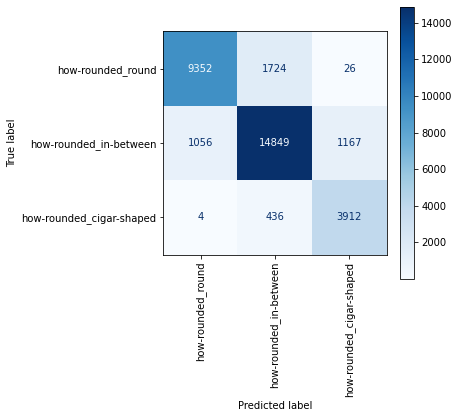

((0.8673284166717908, 0.8643239254750046, 0.8648127716668259, None), 32526)

In [15]:
evalQuestion(predicted_fractions, decals_test, schema.get_question('how-rounded'))

In [16]:
total_report = {}
for question in label_metadata.decals_pairs:
    question_report, support = evalQuestion(predicted_fractions, decals_test, schema.get_question(question), graphs=False)
    total_report[question] = {
        'precision': question_report[0],
        'recall': question_report[1],
        'f1': question_report[2],
        'support': support
    }

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
report_df = pd.DataFrame.from_dict(total_report, orient='index')
report_df

,precision,recall,f1,support
smooth-or-featured,0.869127,0.862852,0.864577,49917
disk-edge-on,0.954622,0.955131,0.954742,15445
has-spiral-arms,0.867833,0.874956,0.869333,11380
bar,0.673015,0.696485,0.661984,11380
bulge-size,0.674946,0.691125,0.671747,11380
how-rounded,0.867328,0.864324,0.864813,32526
edge-on-bulge,0.785438,0.815758,0.784314,2475
spiral-winding,0.677160,0.690225,0.678048,7499
spiral-arm-count,0.652455,0.663555,0.642025,7499
merging,0.845050,0.880338,0.848200,49247


In [18]:
report_df.to_csv("../results/resNet/model_res_weightedstats.csv")